In [1]:
import sys
sys.path.append("/home/salmon/workspace/fytok/python")
sys.path.append("/home/salmon/workspace/SpDev/SpCommon")
sys.path.append("/home/salmon/workspace/SpDev/SpDB")

import collections
from spdm.util.logger import logger
from spdm.data.Collection import Collection
import matplotlib.pyplot as plt
import numpy as np
from scipy import special
import math

In [2]:
db = Collection("cfetr+mdsplus:///home/salmon/public_data/~t/",default_tree_name="efit_east")
entry = db.open(shot=55555).entry

2020-10-23 13:10:51,700 DEBUG [spdm] /home/salmon/workspace/SpDev/SpCommon/spdm/util/sp_export.py:76:sp_find_module: Can not find module spdm.data.plugins.Plugincfetr#cfetrCollection
2020-10-23 13:10:51,702 DEBUG [spdm] /home/salmon/workspace/SpDev/SpCommon/spdm/util/sp_export.py:76:sp_find_module: Can not find module spdm.data.plugins.PluginCfetr#CfetrCollection
2020-10-23 13:10:51,707 DEBUG [spdm] /home/salmon/workspace/SpDev/SpCommon/spdm/util/sp_export.py:74:sp_find_module: spdm.data.plugins.PluginCFETR#CFETRCollection
2020-10-23 13:10:51,708 INFO [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/data/Plugin.py:77:find_plugin: Load Plugin: CFETRCollection
2020-10-23 13:10:51,747 DEBUG [spdm] /home/salmon/workspace/SpDev/SpCommon/spdm/util/sp_export.py:74:sp_find_module: spdm.data.plugins.PluginMDSplus#MDSplusCollection
2020-10-23 13:10:51,748 INFO [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/data/Plugin.py:77:find_plugin: Load Plugin: MDSplusCollection
2020-10-23 13:10:51,749 DEBUG [s

In [12]:
COIL=collections.namedtuple("COIL", "label r z current turns")
def psi(r, z, coils):
    def green_function(Rc, Zc, R, Z):
        k2   =  4.0*Rc*R/((Rc+R)*(Rc+R)+(Zc-Z)*(Zc-Z))          
        return   math.sqrt(R*Rc)/(2.0*math.pi)* ((2.0-k2) * special.ellipk(k2) - 2.0* special.ellipe(k2))/math.sqrt(k2)  
    return sum([green_function(coil.r, coil.z, r, z)*coil.current for coil in coils])

In [13]:
vessel_inner_points= np.array([entry.wall.description_2d.vessel.annular.outline_inner.r.__value__(),    
                                          entry.wall.description_2d.vessel.annular.outline_inner.z.__value__()]).transpose([1,0]) 

vessel_outer_points= np.array([entry.wall.description_2d.vessel.annular.outline_outer.r.__value__(),    
                                          entry.wall.description_2d.vessel.annular.outline_outer.z.__value__()]).transpose([1,0])  


# tf_inner_points= np.array([entry.tf.coil.outline_inner.r.__value__(),    
#                                           entry.tf.coil.outline_inner.z.__value__()]).transpose([1,0]) 

# tf_outer_points= np.array([entry.tf.coil.outline_outer.r.__value__(),    
#                                           entry.tf.coil.outline_outer.z.__value__()]).transpose([1,0])  

limiter_points =  np.array([entry.wall.description_2d[0].limiter.unit[0].outline.r.__value__(),
                                 entry.wall.description_2d[0].limiter.unit[0].outline.z.__value__()]).transpose([1,0]) 

In [31]:
itime=30000

pf_coils=[] 
rpos=[]
zpos=[]
 
itime=40000
I0=[1,1,1,1,1,1,1.4,1.9,1.4,1.2,-1.6,-1.1,-1.5,-0.8,-0.9]
for idx,coil in enumerate(entry.pf_active.coil): 
    rect=coil.element[0].geometry.rectangle.__value__()
    rpos.append(rect.r-rect.width/2.0)
    rpos.append(rect.r+rect.width/2.0)
    zpos.append(rect.z-rect.height/2.0)
    zpos.append(rect.z+rect.height/2.0)  
    pf_coils.append(COIL(coil.name.__value__(),
     rect.r*1.0,rect.z*1.0, I0[idx],  (coil.element[0].turns_with_sign*1 ) ))
    # pf_coils.append(COIL(rect.r*1.0,rect.z*1.0,Ic[idx] ) )
    # print((idx,coil.name.__value__()))
    print(coil.name)

rmin=min(rpos)
rmax=max(rpos)
zmin=min(zpos)
zmax=max(zpos)
NX=100
NY=100
X, Y  = np.meshgrid(np.linspace(rmin, rmax, NX),np.linspace(zmin, zmax, NY))
Z=np.ndarray([NX,NY])
for ix in range(NX):
    for iy in range(NY):
        Z[ix,iy]=psi(X[ix,iy],Y[ix,iy],pf_coils)

CS1U
CS2U
CS3U
CS4U
CS4L
CS3L
CS2L
CS1L
PF1 
PF2 
PF3 
PF4 
PF5 
PF6 
PF7 


(1.62, 1.025, 'CS1U')
(1.62, 3.075, 'CS2U')
(1.62, 5.125, 'CS3U')
(1.62, 7.175, 'CS4U')
(1.62, -7.175, 'CS4L')
(1.62, -5.125, 'CS3L')
(1.62, -3.075, 'CS2L')
(1.62, -1.025, 'CS1L')
(4.6, 9.83, 'PF1 ')
(13.03, 6.653, 'PF2 ')
(15.3, 3.3, 'PF3 ')
(15.3, -3.3, 'PF4 ')
(14.91, -6.25, 'PF5 ')
(7.13, -10.0, 'PF6 ')
(4.6, -9.83, 'PF7 ')


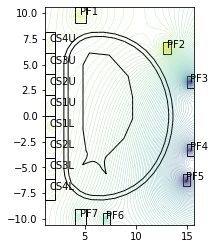

In [45]:
fg=plt.figure()

plt.gca().add_patch(plt.Polygon(limiter_points , fill=False,closed=True))
plt.gca().add_patch(plt.Polygon(vessel_outer_points , fill=False,closed=True))
plt.gca().add_patch(plt.Polygon(vessel_inner_points , fill=False,closed=True))

for coil  in entry.pf_active.coil:
    rect=coil.element[0].geometry.rectangle.__value__() 
    plt.text(float(rect.r),float(rect.z),str(coil.name))
    plt.gca().add_patch(plt.Rectangle((rect.r-rect.width/2.0, rect.z-rect.height/2.0), rect.width, rect.height, fill=False))
 
plt.contour(X,Y,Z,levels=140,linewidths=0.2)

# plt.contour(
#     entry.equilibrium.time_slice[10].profiles_2d.grid.dim1.__value__(),
#     entry.equilibrium.time_slice[10].profiles_2d.grid.dim2.__value__(),
#     entry.equilibrium.time_slice[10].profiles_2d.psi.__value__(),
#     levels= 20,
#     linewidths=0.5)

plt.axis('scaled')
plt.show()

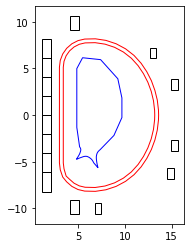

In [26]:
fg=plt.figure()

plt.gca().add_patch(plt.Polygon(limiter_points , fill=False,closed=True,color="blue"))
plt.gca().add_patch(plt.Polygon(vessel_inner_points , fill=False,closed=True,color="red"))
plt.gca().add_patch(plt.Polygon(vessel_outer_points , fill=False,closed=True,color="red"))

for coil  in entry.pf_active.coil:
    rect=coil.element[0].geometry.rectangle.__value__() 
    plt.gca().add_patch(plt.Rectangle((rect.r-rect.width/2.0, rect.z-rect.height/2.0), rect.width, rect.height, fill=False))
 
# plt.contour(X,Y,Z,levels=140,linewidths=0.2)

# plt.contour(
#     entry.equilibrium.time_slice[10].profiles_2d.grid.dim1.__value__(),
#     entry.equilibrium.time_slice[10].profiles_2d.grid.dim2.__value__(),
#     entry.equilibrium.time_slice[10].profiles_2d.psi.__value__(),
#     levels= 20,
#     linewidths=0.5)

plt.axis('scaled')
plt.show()

In [28]:
sys.path.append("/home/salmon/workspace/freegs/")
import freegs
from freegs.machine import Machine,Wall
import freegs.equilibrium as equilibrium
import freegs.jtor as jtor
import freegs.picard as picard
import freegs.boundary as boundary
from  freegs.coil import Coil

itime=40000
coils = []
for coil in entry.pf_active.coil:
    rect = coil.element[0].geometry.rectangle.__real_value__()
    # Ip = coil.current.data.__value__()[itime] 
    turns=coil.element[0].turns_with_sign*1
    coils.append((coil.name.__value__(), Coil(rect["r"], rect["z"], turns=turns,control=True)))

wall = Wall(entry.wall.description_2d[0].limiter.unit[0].outline.r.__value__(),
            entry.wall.description_2d[0].limiter.unit[0].outline.z.__value__())

CFETRTokamak = Machine(coils, wall)

profiles = jtor.ConstrainPaxisIp(1e3,  # Plasma pressure on axis [Pascals]
                            1e6,  # Plasma current [Amps]
                            1.0)  # fvac = R*Bt

psivals = [ (R, Z, 0.0) for R, Z in zip(wall.R,wall.Z)]
# psivals = [ (R, Z, 0.0) for R, Z in zip(entry.equilibrium.time_slice[10].boundary.outline.r.__value__(), 
#             entry.equilibrium.time_slice[10].boundary.outline.z.__value__()) ]
xpoints = [(1.1, -0.6),   # (R,Z) locations of X-points
           (1.1, 0.8)]

isoflux = [(1.1,-0.6, 1.1,0.6)] # (R1,Z1, R2,Z2) pair of locations

constrain = freegs.control.constrain(xpoints=xpoints, isoflux=isoflux)

rmin=min(limiter_points[0])
rmax=max(limiter_points[0])
zmin=min(limiter_points[1])
zmax=max(limiter_points[1])

eq = equilibrium.Equilibrium(tokamak=EASTTokamak,
                                Rmin=rmin, Rmax=rmax,
                                Zmin=zmin, Zmax=zmax,
                                nx=129, ny=129,
                                boundary=boundary.freeBoundaryHagenow)

freegs.solve(eq, profiles,constrain, psi_bndry=0.0) 

ValueError: No O-points found!

In [ ]:
fg=plt.figure()

plt.gca().add_patch(plt.Polygon(limiter_points , fill=False,closed=True))
plt.gca().add_patch(plt.Polygon(vessel_outer_points , fill=False,closed=True))
plt.gca().add_patch(plt.Polygon(vessel_inner_points , fill=False,closed=True))

plt.show()for coil  in entry.pf_active.coil:
    rect=coil.element[0].geometry.rectangle.__value__() 
    plt.gca().add_patch(plt.Rectangle((rect.r-rect.width/2.0, rect.z-rect.height/2.0), rect.width, rect.height, fill=False))
 
plt.contour(X,Y,Z,levels=100,linewidths=0.1,linestyles="dotted")

plt.contour(
    entry.equilibrium.time_slice[10].profiles_2d.grid.dim1.__value__(),
    entry.equilibrium.time_slice[10].profiles_2d.grid.dim2.__value__(),
    entry.equilibrium.time_slice[10].profiles_2d.psi.__value__(),
    linewidths=0.5,cmap="gray")

plt.contour(np.linspace(rmin,rmax,129),np.linspace(zmin,zmax,129),eq.psi().transpose(-1,0),levels= 40,linewidths=0.5)

plt.axis('scaled')
